# New York CitiBike Data Science Challenge

Der Fahrradverleih CitiBike vermietet in New York über 12.000 Fahrräder an 750 
Verleihstationen. Somit ist CitiBike eine echte Alternative zu den herkömmlichen 
Transportmitteln, wie z.B. U-bahn oder Taxi. 

Nehme an, es wäre das Jahr 2018. Mit einem gültigen 24 Stunden (3 Tage) Pass bzw. einer 
jährlichen Mitgliedschaft können Kunden ein Fahrrad an einer Verleihstation abholen und an 
einer beliebigen Station wieder abgeben. CitiBike stellt die durch den Verleih gesammelten 
Daten der Öffentlichkeit zur Verfügung. Deine Aufgabe als Data Scientist ist es, CitiBike dabei zu
helfen diese Daten wertstiftend zu nutzen. 

In einem ersten Pilotprojekt sollst du hierfür die Daten analysieren und ein Modell bauen, mit 
welchem zwei Klassen von Nutzern identifiziert werden können; dies sind (i) customers (24 
Stunden/ 3 Tage Pass) und (ii) subscribers (jährliche Mitgliedschaft).

Eine Orientierungshilfe bei 
dieser Aufgabenstellung bieten dir die folgenen Arbeitsschritte:
 
1. Lade diese Daten von Citibike für das Jahr 2018 herunter. Mach dich mit dem Inhalt des 
Datensatzes vertraut und bereite ihn für weitere Analysen auf. 
2. Visualisiere die Daten; sei kreativ und überlege dir geeignete Darstellungsformen für 
deine Entdeckungen. Nutze die Visualisierungen auch in deiner Ergebnispräsentation um 
deine Argumente zu unterstützen.
3. Überlege dir geeignete Features (Merkmale) als Input für dein customer-subscriber-
Modell. Konstruiere gegebenenfalls neue Features um dein Modell zu verbessern. 
4. Verteste verschiedene Modelle bzw. Methoden zur Klassifikation der Kundentypen 
subscribers und customers. Evaluiere die Performance der unterschiedlichen Modelle 
und begründe eine Modellauswahl.
5. Skizziere mögliche Einsatzgebiete oder UseCases deiner Modelle
6. Skizziere für CitiBike Kooperationsmöglichkeiten mit einer Versicherung (und/oder 
umgekehrt). 
 


## Imports und Co

In [1]:
# Generelles
import os

# Data science
import numpy as np
import pandas as pd

# Machine learning
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import shap

# Plotting
import matplotlib.pyplot as plt

# Hilfen
from utils import crow_distance
from utils import forward_feature_selection

# Display
pd.set_option('display.max_columns', 500)
%matplotlib inline 

# Random seed
random_seed = 1
np.random.seed(random_seed)

# Konstanten
data_drop = 0.99
max_trip_duration = 12 * 3600

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Datenvorbereitung

In [2]:
# Rohdaten einlesen, wir beschränken uns auf 1% der Daten um meine virtuelle Maschine zu schonen
data_directory = 'data_NY/'
files = sorted(os.listdir(data_directory))
for index, file in enumerate(files):
    if index == 0:
        data = pd.read_csv(data_directory+file)
        data.drop(np.random.choice(data.index, int(len(data)*data_drop), replace=False), inplace=True)
    else:
        data_tmp = pd.read_csv(data_directory+file)
        data_tmp.drop(np.random.choice(data_tmp.index, int(len(data_tmp)*data_drop), replace=False), inplace=True)
        data = pd.concat([data, data_tmp], ignore_index=True)

# Datentyp verbessern
for column in data.columns:
    data.rename(columns={column: column.replace(' ', '_')}, inplace=True)
data.starttime = pd.to_datetime(data.starttime)
data.stoptime = pd.to_datetime(data.stoptime)

# Rohdaten sichten
data

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,1777,2018-06-01 15:10:55.401,2018-06-01 15:40:32.579,3183,Exchange Place,40.716247,-74.033459,3183,Exchange Place,40.716247,-74.033459,26304,Customer,1969,0
1,307,2018-06-01 16:20:51.702,2018-06-01 16:25:59.092,3183,Exchange Place,40.716247,-74.033459,3213,Van Vorst Park,40.718489,-74.047727,29472,Subscriber,1986,1
2,407,2018-06-01 17:57:26.303,2018-06-01 18:04:13.992,3183,Exchange Place,40.716247,-74.033459,3211,Newark Ave,40.721525,-74.046305,26230,Subscriber,1985,1
3,481,2018-06-05 15:16:27.586,2018-06-05 15:24:29.260,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,33649,Subscriber,1990,1
4,1468,2018-06-05 17:43:20.254,2018-06-05 18:07:48.704,3183,Exchange Place,40.716247,-74.033459,3207,Oakland Ave,40.737604,-74.052478,33658,Subscriber,1981,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,101,2018-08-16 22:38:17.553,2018-08-16 22:39:59.252,3681,Grand St,40.715178,-74.037683,3267,Morris Canal,40.712419,-74.038526,29591,Subscriber,1989,2
1274,123,2018-08-24 08:00:15.406,2018-08-24 08:02:19.171,3681,Grand St,40.715178,-74.037683,3275,Columbus Drive,40.718355,-74.038914,33626,Subscriber,1974,1
1275,383,2018-08-27 07:56:52.337,2018-08-27 08:03:16.210,3681,Grand St,40.715178,-74.037683,3202,Newport PATH,40.727224,-74.033759,33588,Subscriber,1970,1
1276,135,2018-08-27 08:34:18.690,2018-08-27 08:36:33.990,3681,Grand St,40.715178,-74.037683,3183,Exchange Place,40.716247,-74.033459,29520,Subscriber,1987,1


In [3]:
# Sanity checks der Rohdaten

print('Tripduration')
print(f'Min: {np.min(data.tripduration)} s, Max: {np.max(data.tripduration)/3600:.0f} h\n')

print('Starttime')
print(f'Min: {np.min(data.starttime)}, Max: {np.max(data.starttime)}\n')

print('Stoptime')
print(f'Min: {np.min(data.stoptime)}, Max: {np.max(data.stoptime)}\n')

print('Start station id')
print(f'Min: {np.min(data.start_station_id)}, Max: {np.max(data.start_station_id)}, #: {len(np.unique(data.start_station_id))}\n')

# print('Start station name')
# print(f'#: {len(np.unique(data.start_station_name))}\n')
      
print('Start station latitude')
print(f'Min: {np.min(data.start_station_latitude)}, Max: {np.max(data.start_station_latitude)}, #: {len(np.unique(data.start_station_latitude))}\n')

print('Start station longtude')
print(f'Min: {np.min(data.start_station_longitude)}, Max: {np.max(data.start_station_longitude)}, #: {len(np.unique(data.start_station_longitude))}\n')

print('End station id')
print(f'Min: {np.min(data.end_station_id)}, Max: {np.max(data.end_station_id)}, #: {len(np.unique(data.end_station_id))}\n')

# print('End station name')
# print(f'#: {len(np.unique(data.end_station_name))}\n')

print('End station latitude')
print(f'Min: {np.min(data.end_station_latitude)}, Max: {np.max(data.end_station_latitude)}, #: {len(np.unique(data.end_station_latitude))}\n')

print('End station longitude')
print(f'Min: {np.min(data.end_station_longitude)}, Max: {np.max(data.end_station_longitude)}, #: {len(np.unique(data.end_station_longitude))}\n')

print('Bikeid')
print(f'Min: {np.min(data.bikeid)}, Max: {np.max(data.bikeid)}, #: {len(np.unique(data.bikeid))}\n')

print('Usertype')
print(f'Types: {np.unique(data.usertype)}, #: {np.unique(data.usertype, return_counts=True)[1]}\n')

print('Birth year')
print(f'Min: {np.min(data.birth_year)}, Max: {np.max(data.birth_year)}\n')

print('Gender')
print(f'Types: {np.unique(data.gender)}, #: {np.unique(data.gender, return_counts=True)[1]}\n')

Tripduration
Min: 67 s, Max: 40 h

Starttime
Min: 2018-06-01 07:25:42.717000, Max: 2018-08-31 20:57:51.790000

Stoptime
Min: 2018-06-01 07:28:33.779000, Max: 2018-08-31 21:14:57.124000

Start station id
Min: 3183, Max: 3694, #: 50

Start station latitude
Min: 40.71113, Max: 40.74871594538023, #: 50

Start station longtude
Min: -74.0836394, Max: -74.0321082, #: 50

End station id
Min: 453, Max: 3681, #: 50

End station latitude
Min: 40.7112423, Max: 40.74871594538023, #: 50

End station longitude
Min: -74.0836394, Max: -73.99915362, #: 50

Bikeid
Min: 15444, Max: 33695, #: 535

Usertype
Types: ['Customer' 'Subscriber'], #: [  92 1186]

Birth year
Min: 1888, Max: 2000

Gender
Types: [0 1 2], #: [ 96 922 260]



In [4]:
# Daten säubern

# Sortiere Fahrten aus, die länger als 2 Stunden dauerten
len_before = len(data)
data.drop(data[data.tripduration >= max_trip_duration].index, inplace=True)
len_after = len(data)
print(f'Dropped {len_before-len_after} lines due to excessive tripduration')

# Macht es Sinn, Geburtsjahre vor 1918 auszusortieren?

Dropped 3 lines due to excessive tripduration


### Erstes Fazit

- Datensatz sehr groß, wir beschränken uns deswegen auf die Sommermonate
- Datensatz ist 'imbalanced', 19 000 customer gegen 156 000 subscriber
- Datenqualität ist okay, aber ein paar sehr alte Kunden, lange Fahrten und unhomogene Koordinatenangaben
- Wir sollten schon vor der weiteren Analyse einen Teil der Daten beiseitelegen, um eine wirklich unabhängige Evaluation unseres Modells zu erreichen
- Wir sollten schon bei der visuellen Analyse des Datensatzes die Aufgabenstellung im Auge behalten

## Features für Customer-Subscriber-Modell

In [5]:
data['start_hour_of_day']= [t.hour for t in data.starttime]

data['start_day_of_week'] = [t.dayofweek for t in data.starttime]

data['start_day_of_year'] = [t.dayofyear for t in data.starttime]

data['duration_seconds'] = data.tripduration

data['crow_distance_meters'] = crow_distance(data.start_station_latitude, data.start_station_longitude, data.end_station_latitude, data.end_station_longitude)

data['crow_velocity_meters_per_second'] = data.crow_distance_meters / data.duration_seconds

data['age'] = 2018 - data.birth_year

data['gender_male'] = [1 if g==1 else 0 for g in data.gender]

data['gender_female'] = [1 if g==2 else 0 for g in data.gender]

data['gender_unknown'] = [1 if g==0 else 0 for g in data.gender]

data['customer'] = [1 if u=='Customer' else 0 for u in data.usertype]

data['subscriber'] = [1 if u=='Subscriber' else 0 for u in data.usertype]

data['set'] = [np.random.choice(['train', 'dev', 'test'], p=[0.8, 0.1, 0.1]) for r in range(len(data))]

data['train_set'] = [True if s=='train' else False for s in data.set]

data['dev_set'] = [True if s=='dev' else False for s in data.set]

data['test_set'] = [True if s=='test' else False for s in data.set]

data

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_hour_of_day,start_day_of_week,start_day_of_year,duration_seconds,crow_distance_meters,crow_velocity_meters_per_second,age,gender_male,gender_female,gender_unknown,customer,subscriber,set,train_set,dev_set,test_set
0,1777,2018-06-01 15:10:55.401,2018-06-01 15:40:32.579,3183,Exchange Place,40.716247,-74.033459,3183,Exchange Place,40.716247,-74.033459,26304,Customer,1969,0,15,4,152,1777,0.000000,0.000000,49,0,0,1,1,0,train,True,False,False
1,307,2018-06-01 16:20:51.702,2018-06-01 16:25:59.092,3183,Exchange Place,40.716247,-74.033459,3213,Van Vorst Park,40.718489,-74.047727,29472,Subscriber,1986,1,16,4,152,307,1230.214782,4.007214,32,1,0,0,0,1,train,True,False,False
2,407,2018-06-01 17:57:26.303,2018-06-01 18:04:13.992,3183,Exchange Place,40.716247,-74.033459,3211,Newark Ave,40.721525,-74.046305,26230,Subscriber,1985,1,17,4,152,407,1307.441514,3.212387,33,1,0,0,0,1,train,True,False,False
3,481,2018-06-05 15:16:27.586,2018-06-05 15:24:29.260,3183,Exchange Place,40.716247,-74.033459,3199,Newport Pkwy,40.728745,-74.032108,33649,Subscriber,1990,1,15,1,156,481,1496.048973,3.110289,28,1,0,0,0,1,train,True,False,False
4,1468,2018-06-05 17:43:20.254,2018-06-05 18:07:48.704,3183,Exchange Place,40.716247,-74.033459,3207,Oakland Ave,40.737604,-74.052478,33658,Subscriber,1981,1,17,1,156,1468,3216.574183,2.191127,37,1,0,0,0,1,train,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,101,2018-08-16 22:38:17.553,2018-08-16 22:39:59.252,3681,Grand St,40.715178,-74.037683,3267,Morris Canal,40.712419,-74.038526,29591,Subscriber,1989,2,22,3,228,101,329.105768,3.258473,29,0,1,0,0,1,train,True,False,False
1274,123,2018-08-24 08:00:15.406,2018-08-24 08:02:19.171,3681,Grand St,40.715178,-74.037683,3275,Columbus Drive,40.718355,-74.038914,33626,Subscriber,1974,1,8,4,236,123,412.368844,3.352592,44,1,0,0,0,1,train,True,False,False
1275,383,2018-08-27 07:56:52.337,2018-08-27 08:03:16.210,3681,Grand St,40.715178,-74.037683,3202,Newport PATH,40.727224,-74.033759,33588,Subscriber,1970,1,7,0,239,383,1437.733658,3.753874,48,1,0,0,0,1,train,True,False,False
1276,135,2018-08-27 08:34:18.690,2018-08-27 08:36:33.990,3681,Grand St,40.715178,-74.037683,3183,Exchange Place,40.716247,-74.033459,29520,Subscriber,1987,1,8,0,239,135,345.356783,2.558198,31,1,0,0,0,1,dev,False,True,False


## Visualisierungen

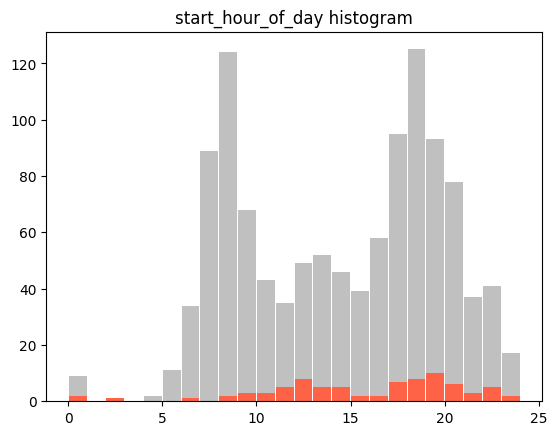

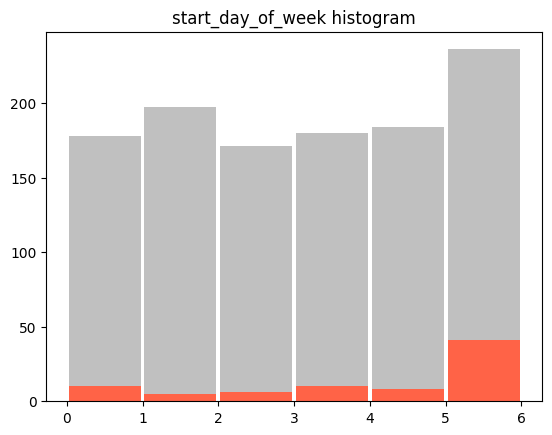

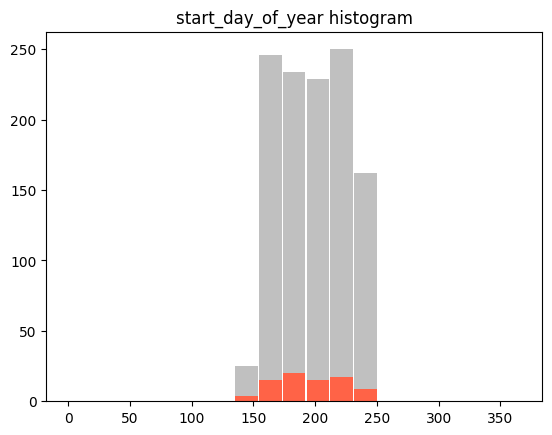

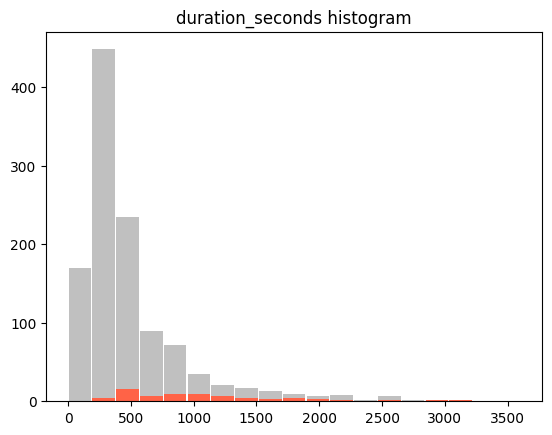

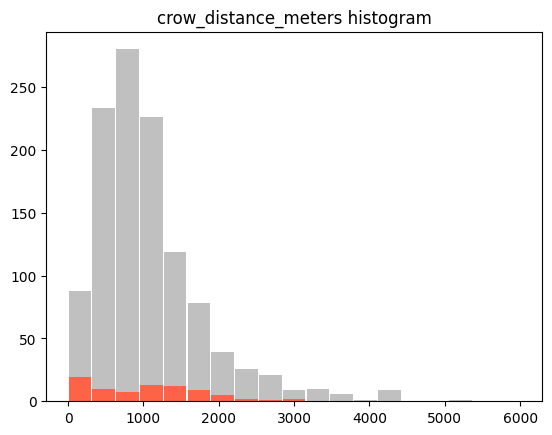

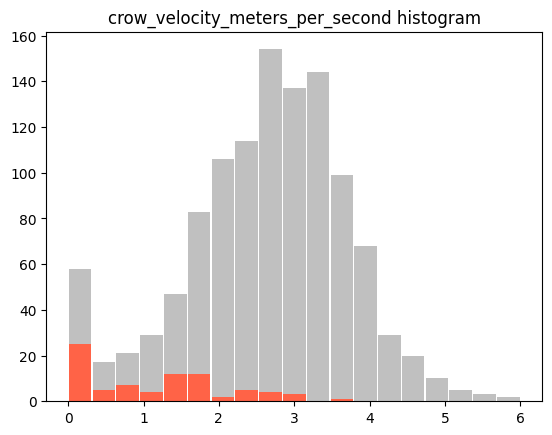

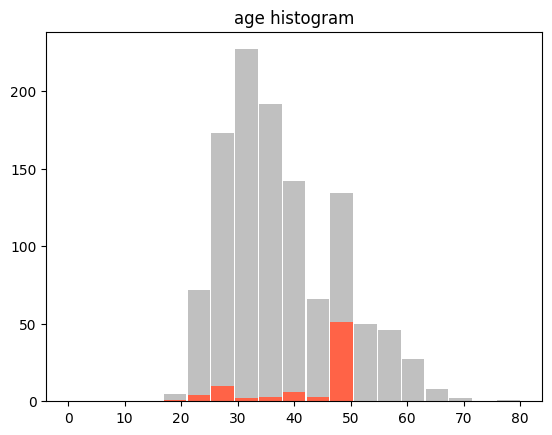

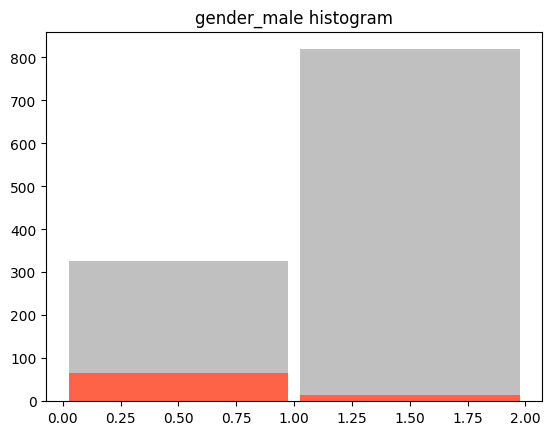

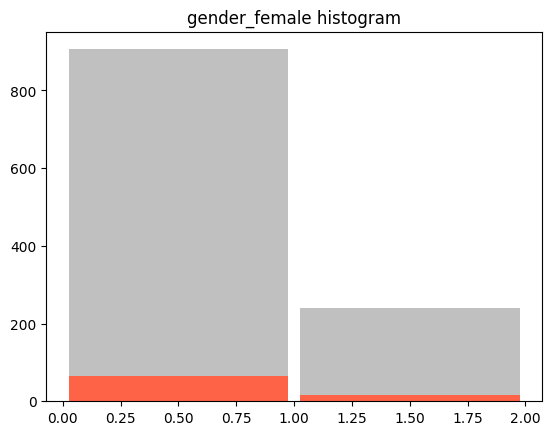

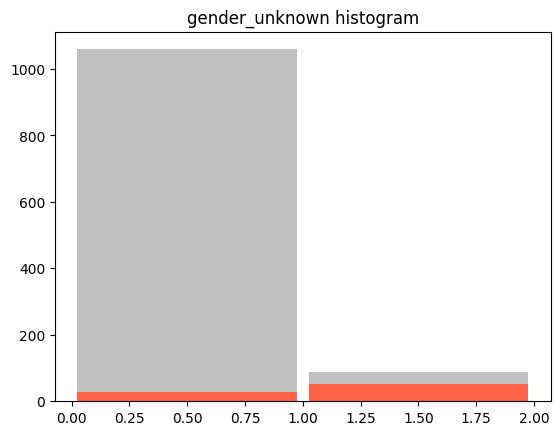

In [6]:
# histogramme, sortiert nach customer und Subscriber
plot_specs = [('start_hour_of_day', range(25)),
              ('start_day_of_week', range(7)),
              ('start_day_of_year', np.linspace(0, 366, num=20)),
              ('duration_seconds', np.linspace(0, 3600, num=20)),
              ('crow_distance_meters', np.linspace(0, 6000, num=20)),
              ('crow_velocity_meters_per_second', np.linspace(0, 6, num=20)),
              ('age', np.linspace(0, 80, num=20)),
              ('gender_male', range(3)),
              ('gender_female', range(3)),
              ('gender_unknown', range(3))]

data_customer = data[~data.test_set & data.customer==1]
data_subscriber = data[~data.test_set & data.subscriber==1]

for column, bins in plot_specs:
    plt.hist([data_customer[column], data_subscriber[column]], bins, stacked=True, rwidth=.95, color=['tomato', 'silver'])
    plt.title(f'{column} histogram')
    plt.show()
    plt.close()

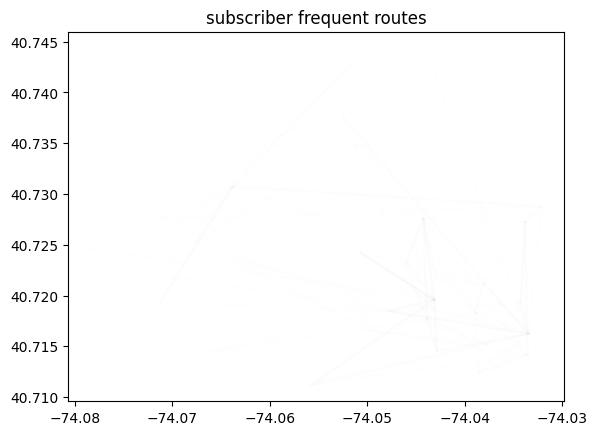

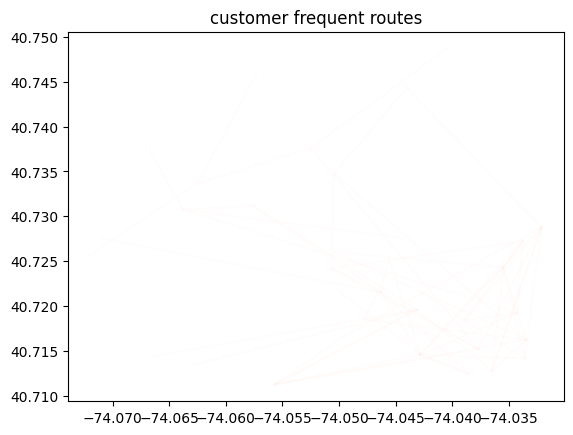

In [7]:
# Wegstrecken, ebenfalls nach customer und subscriber 
data_subscriber_for_plot = data_subscriber.drop(np.random.choice(data_subscriber.index, int(len(data_subscriber)*0.9), replace=False))
for idx, row in data_subscriber_for_plot.iterrows():
    plt.plot([row.start_station_longitude, row.end_station_longitude], [row.start_station_latitude, row.end_station_latitude], alpha=0.01, color='silver')
plt.title('subscriber frequent routes')
plt.show()
plt.close()

for idx, row in data_customer.iterrows():
    plt.plot([row.start_station_longitude, row.end_station_longitude], [row.start_station_latitude, row.end_station_latitude], alpha=0.01, color='tomato')
plt.title('customer frequent routes')
plt.show()
plt.close()

## Modelle

In [8]:
# Inputs definieren
feature_columns = ['start_hour_of_day',
                   'start_day_of_week',
                   'start_day_of_year',
                   'duration_seconds',
                   'crow_distance_meters',
                   'crow_velocity_meters_per_second',
                   'age',
                   'gender_male',
                   'gender_female',
                   'gender_unknown']

target_column = ['customer']

# Training und validation Daten
x_train = data.loc[data.train_set, feature_columns]
x_dev = data.loc[data.dev_set, feature_columns]
y_train = data.loc[data.train_set, target_column]
y_dev = data.loc[data.dev_set, target_column]

In [9]:
# Simples Modell fitten: immer als Subscriber klassifizieren
simple_model = lambda x: np.array([0]*len(x)) 
y_dev_hat_simple = simple_model(x_dev)

# Lineare Klassifikation fitten
linear_model = SGDClassifier(max_iter=1000, tol=1e-13)
linear_model.fit(x_train, y_train.to_numpy().reshape(-1))
y_dev_hat_linear = linear_model.predict(x_dev)

# Random forest für Klassifikation fitten
random_forest_model = RandomForestClassifier(n_estimators=500)#  !! TODO random seed
random_forest_model.fit(x_train, y_train.to_numpy().reshape(-1))
y_dev_hat_random_forest = random_forest_model.predict(x_dev)

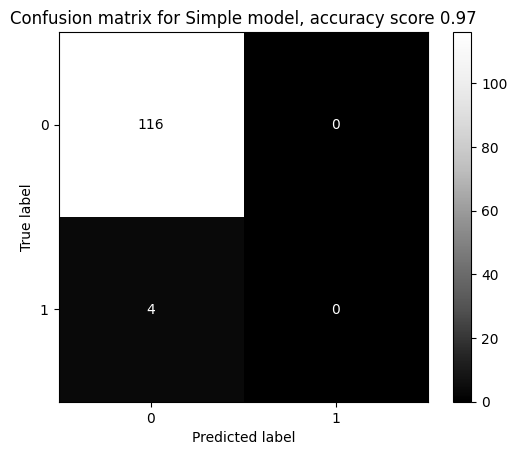

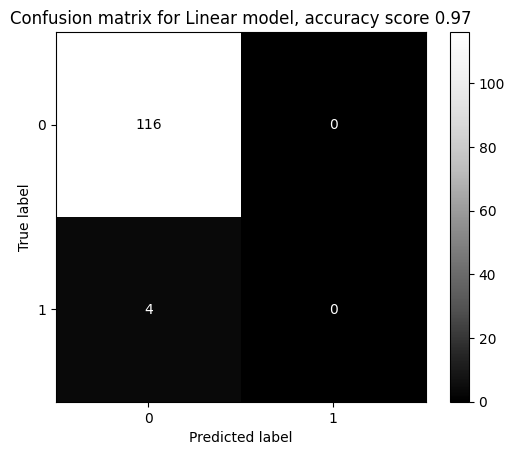

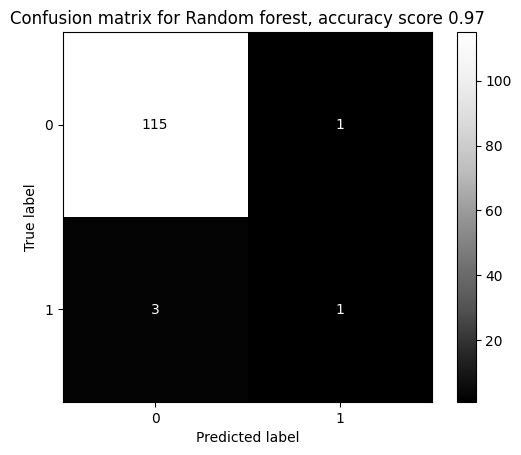

In [10]:
# Confusion matrix and accuracy score
plot_specs = [(y_dev_hat_simple, 'Simple model'),
              (y_dev_hat_linear, 'Linear model'),
              (y_dev_hat_random_forest, 'Random forest')]
for y_dev_hat, model_name in plot_specs:
    acc = accuracy_score(y_dev, y_dev_hat)
    disp = ConfusionMatrixDisplay.from_predictions(y_dev, y_dev_hat, cmap='Greys_r')
    plt.title(f'Confusion matrix for {model_name}, accuracy score {acc:.2f}')
    plt.show()
    plt.close()

In [11]:
# Welche fFatures sind sinnvoll?
selected_features = forward_feature_selection(data, feature_columns, target_column)


testing 2 features:
start_hour_of_day, start_day_of_week: acc = 0.9583
start_hour_of_day, start_day_of_year: acc = 0.9000
start_hour_of_day, duration_seconds: acc = 0.9250
start_hour_of_day, crow_distance_meters: acc = 0.9167
start_hour_of_day, crow_velocity_meters_per_second: acc = 0.9500
start_hour_of_day, age: acc = 0.9417
start_hour_of_day, gender_male: acc = 0.9083
start_hour_of_day, gender_female: acc = 0.9583
start_hour_of_day, gender_unknown: acc = 0.9583
start_day_of_week, start_day_of_year: acc = 0.9500
start_day_of_week, duration_seconds: acc = 0.9250
start_day_of_week, crow_distance_meters: acc = 0.9333
start_day_of_week, crow_velocity_meters_per_second: acc = 0.9583
start_day_of_week, age: acc = 0.9667
start_day_of_week, gender_male: acc = 0.9667
start_day_of_week, gender_female: acc = 0.9667
start_day_of_week, gender_unknown: acc = 0.9500
start_day_of_year, duration_seconds: acc = 0.9417
start_day_of_year, crow_distance_meters: acc = 0.9333
start_day_of_year, crow_veloci

## Use cases für Modelle

- Fahrräder bereitstellen
- Kunden elastizität, vielleicht Pauschale erhöhen?

##  Kooperation mit Versicherung

- ...

## Was ich noch gemacht hätte, wenn ich Zeit gehabt hätte

- Datensatz als Graph betrachten, zwischen welchen Stationen fahren Customer und Subscriber gerne?
- ...